In [1]:
#imports
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam
from functions.eve_optimizer import EpochEVE, EpochEVE2


In [2]:
num_epochs = 30
batch_size = 64

lr = 5e-4
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Sun Sep 19 21:22:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |   3735MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:1'

In [5]:
#creating datasets

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

# Download training data from open datasets.
full_training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
full_test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

#select smaller subset of datasets
# training_dataset = torch.utils.data.Subset(full_training_dataset, [i for i in range(5000)])
# test_dataset = torch.utils.data.Subset(full_test_dataset, [i for i in range(500)])

# Create data loaders.
train_data = DataLoader(full_training_dataset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(full_test_dataset, batch_size=batch_size)

In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.param_updates = 0
        self.lin1 = nn.Linear(28*28, 20)
        self.lin2 = nn.Linear(20, 10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out1 = self.flatten(x)
        out2 = self.lin1(out1)
        out2_1 = self.relu(out2)
        out3 = self.lin2(out2_1)
        logits = self.sigmoid(out3)
        return logits

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
model = Model()
model.to(device)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)

#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
ep_train_loss = np.zeros((num_epochs+1))
test_loss = np.zeros((num_epochs+1))
test_acc = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin1.weight size: 15680
lin1.bias size: 20
lin2.weight size: 200
lin2.bias size: 10
Total num. parameters: 15910
param states shape: (28141, 15910)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader)

    total_loss = 0.0
    
    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()

        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()
        total_loss += loss.item()

        model.param_updates += 1

    return total_loss/size

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_minibatches
    correct /= size
    return test_loss, correct

In [9]:
model.param_updates=0

#Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)
ep_optimizer = None
#ep_optimizer = EpochEVE(model.parameters(), model, loss_fn, train_data, device)
#ep_optimizer = EpochEVE2(model.parameters(), model, loss_fn, train_data, device, step_size=2)

#Getting initial train and test loss
ep_train_loss[0], _ = test(train_data, model, loss_fn)
train_loss[0],_ = test(train_data, model, loss_fn)
test_loss[0],test_acc[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    #Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.9, drop_rate=1)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=1)

    ep_train_loss[j+1] = train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    
    if ep_optimizer != None:
        ep_optimizer.step()
    
    test_loss[j+1],test_acc[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
 - Epoch: 2
 - Epoch: 3
 - Epoch: 4
 - Epoch: 5
 - Epoch: 6
 - Epoch: 7
 - Epoch: 8
 - Epoch: 9
 - Epoch: 10
 - Epoch: 11
 - Epoch: 12
 - Epoch: 13
 - Epoch: 14
 - Epoch: 15
 - Epoch: 16
 - Epoch: 17
 - Epoch: 18
 - Epoch: 19
 - Epoch: 20
 - Epoch: 21
 - Epoch: 22
 - Epoch: 23
 - Epoch: 24
 - Epoch: 25
 - Epoch: 26
 - Epoch: 27
 - Epoch: 28
 - Epoch: 29
 - Epoch: 30


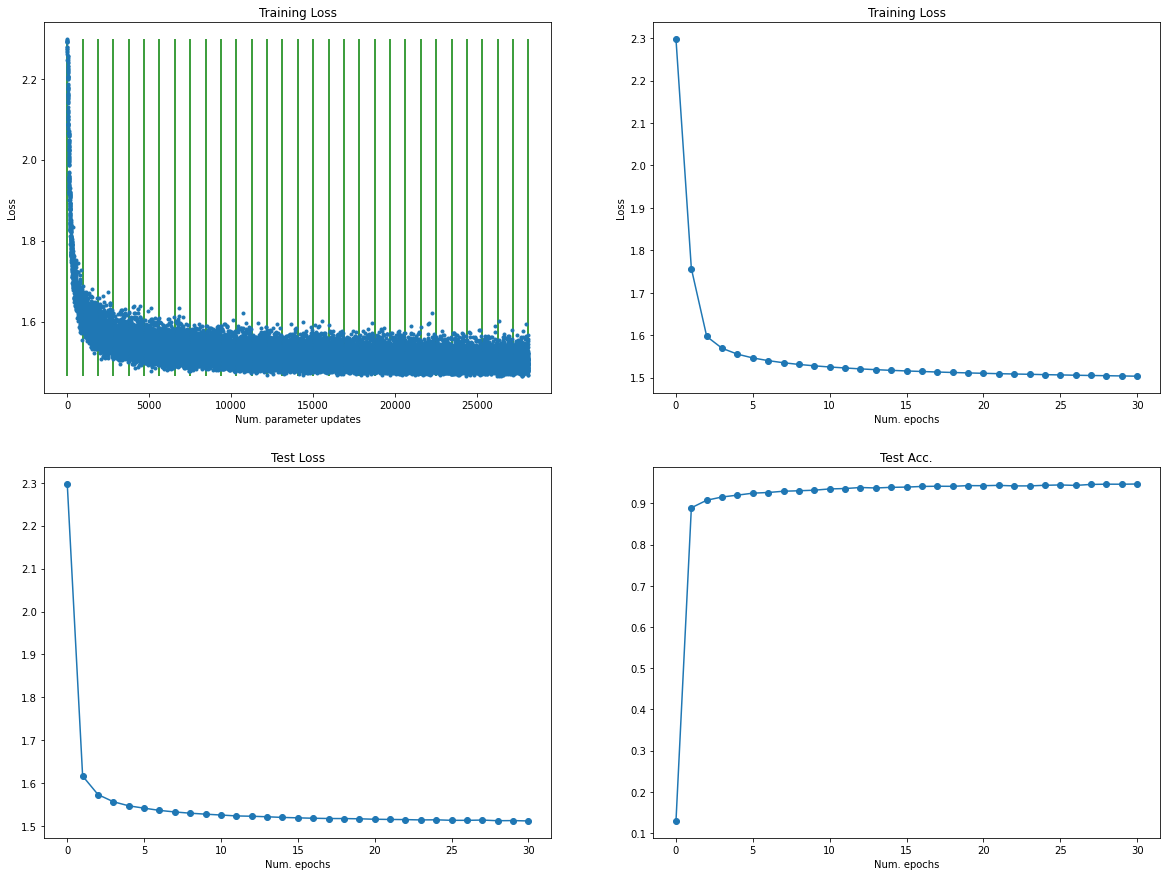

In [10]:
#plotting loss over training
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.plot(train_loss, '.')
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
#plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')
plt.plot(ep_train_loss, 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

plt.subplot(2, 2, 4)
plt.title('Test Acc.')
plt.xlabel('Num. epochs')
plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss, test_acc are self explanatory, except train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss, test_acc are self explanatory, except train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

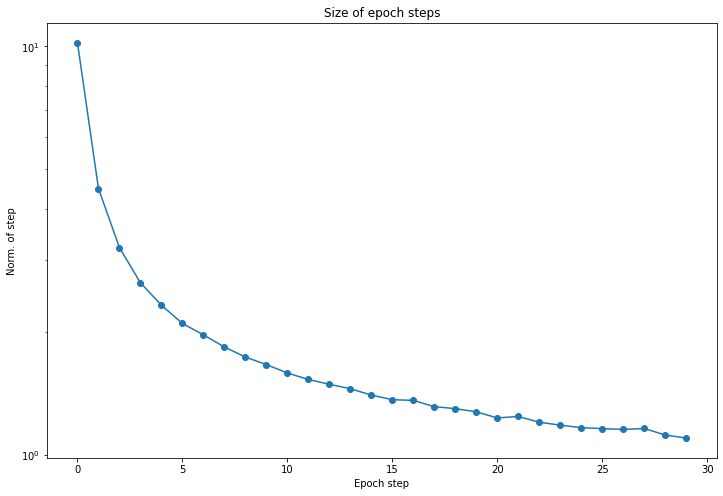

In [12]:
#plotting size of epoch step
plt.figure(figsize=(12,8))
plt.title("Size of epoch steps")
plt.xlabel("Epoch step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot([np.linalg.norm(param_states[int(epoch_indices[i+1])]-param_states[int(epoch_indices[i])]) for i in range(len(epoch_indices)-1)], 'o-')

In [13]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 15910) 
samples shape: (28141, 15910) 
transformed shape: (28141, 2)
PCA explains [0.90711636 0.07150859] -> 97.86249532060005 % of variance


In [14]:
epoch_states = np.array([param_states[int(epoch_indices[i])] for i in range(num_epochs+1)])
print(epoch_states.shape)
epoch_steps = np.array([epoch_states[i+1]-epoch_states[i] for i in range(num_epochs)])
print(epoch_steps.shape)

epoch_states_embed = pca.transform(epoch_states)
epoch_steps_embed = np.array([epoch_states_embed[i+1]-epoch_states_embed[i] for i in range(num_epochs)])
print(epoch_states_embed[0:2])
print(epoch_steps_embed[0])

(31, 15910)
(30, 15910)
[[24.99357613 11.95743891]
 [21.34157152  6.8450133 ]]
[-3.65200461 -5.11242561]


-14.989419313284806 3.991297108323938


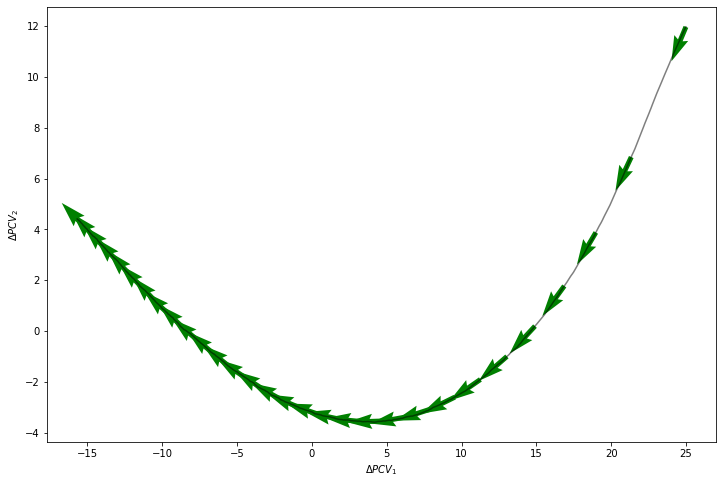

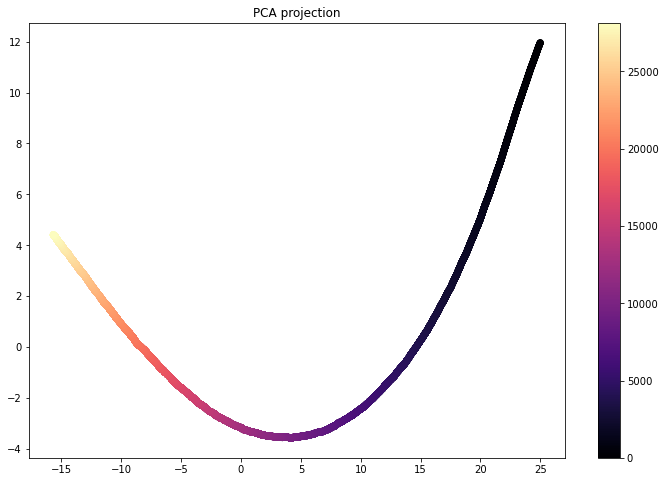

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pca_embed[:,0], pca_embed[:,1], c='k', alpha=0.5)
#ax.scatter(epoch_states_embed[:,0], epoch_states_embed[:,1], c='g')
for i in range(num_epochs):
    ax.quiver(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1], angles='xy', color='g')
    #print(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1])
    #ax.arrow(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1],
    #         color='g', width=0.5, head_width=1, length_includes_head=True)
ax.set_xlabel('$\Delta PCV_{1}$')
ax.set_ylabel('$\Delta PCV_{2}$')
print(*[epoch_states_embed[i,0], epoch_states_embed[i,1]])

plt.figure(figsize=(12, 8))
plt.title('PCA projection')
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=cmap(np.linspace(0, 1, num_param_states)))
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))

Text(0, 0.5, 'Change in train loss / size epoch step')

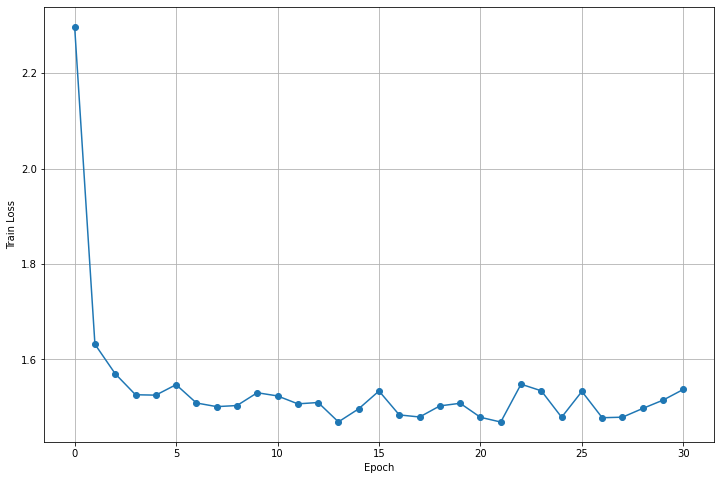

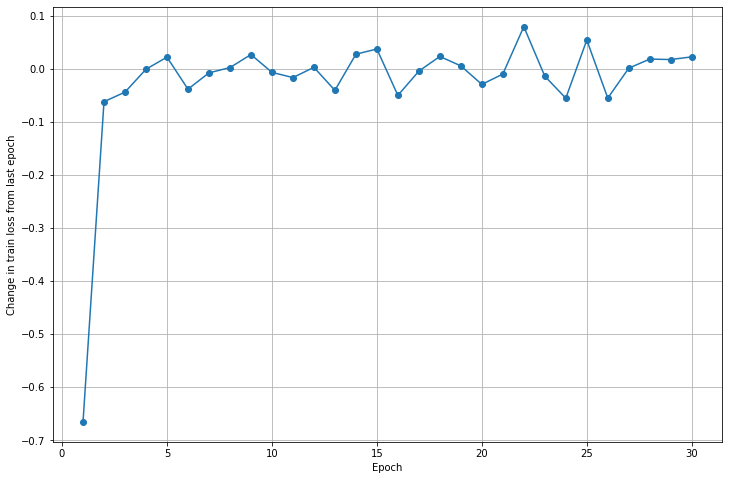

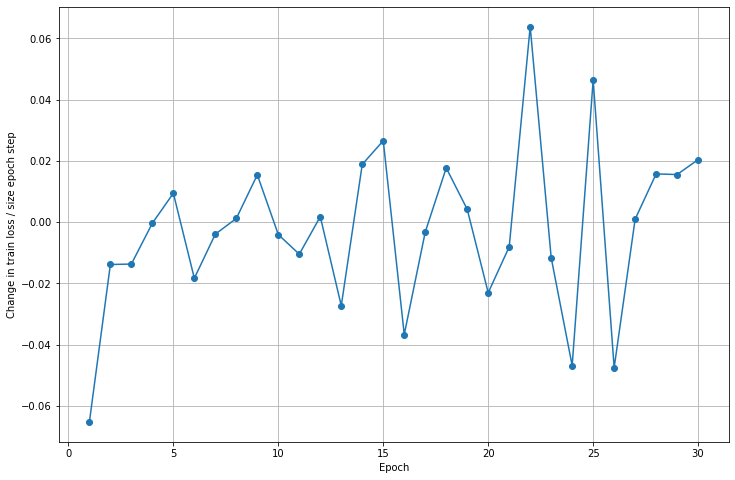

In [16]:
epoch_train_loss = np.asarray(train_loss[[int(v) for v in epoch_indices]])

plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, num_epochs+1), epoch_train_loss, 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

change_epoch_train_loss = epoch_train_loss[1:] - epoch_train_loss[:-1]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, num_epochs+1), change_epoch_train_loss, 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Change in train loss from last epoch")

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, num_epochs+1), change_epoch_train_loss / np.linalg.norm(epoch_steps, axis=-1), 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Change in train loss / size epoch step")

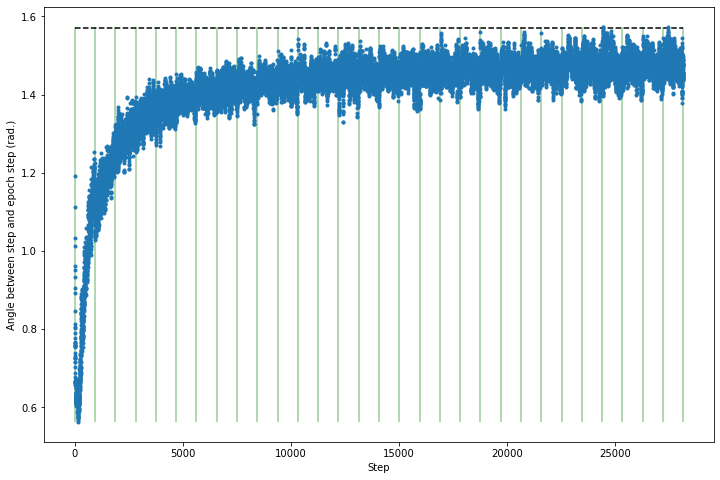

In [17]:
step_dot_prod = np.zeros((num_param_states-1))
for i in range(len(epoch_steps)):
    this_epoch_grad = epoch_steps[i]
    #print("step:", i, 'to', i+1)
    #print('states:', epoch_indices[i+1], 'to', epoch_indices[i+2])
    #for j in range(int(epoch_indices[i+1]), int(epoch_indices[i+2])):
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
        #print(j, np.dot(steps[j], this_epoch_grad))
        step_dot_prod[j] = np.arccos(np.dot(steps[j], this_epoch_grad)/(np.linalg.norm(steps[j])*np.linalg.norm(this_epoch_grad)))
        #step_dot_prod[j] = np.dot(steps[j], this_epoch_grad)/(np.linalg.norm(steps[j])*np.linalg.norm(this_epoch_grad))

plt.figure(figsize=(12,8))
plt.vlines(epoch_indices, ymin=min(step_dot_prod), ymax=max(step_dot_prod), color='g', alpha=0.4)
plt.hlines([np.pi/2], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.xlabel("Step")
plt.ylabel("Angle between step and epoch step (rad.)")
plt.plot(step_dot_prod, '.')
#plt.xlim((0, 50))
        

Text(0, 0.5, 'Angle between grad and epoch step (rad.)')

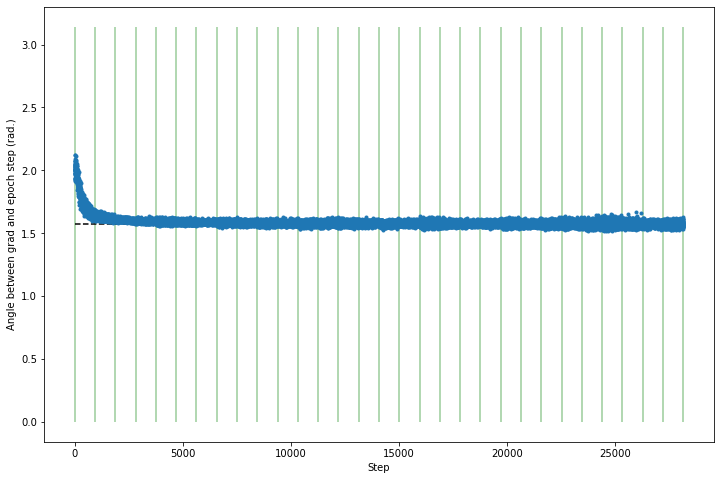

In [18]:
grad_dot_prod = np.zeros((num_param_states-1))
for i in range(len(epoch_steps)):
    this_epoch_grad = epoch_steps[i]
    #print("step:", i, 'to', i+1)
    #print('states:', epoch_indices[i+1], 'to', epoch_indices[i+2])
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
    #for j in range(int(epoch_indices[i+1]), int(epoch_indices[i+2])):
        #print(j, np.dot(steps[j], this_epoch_grad))
        grad_dot_prod[j] = np.arccos(np.dot(grads[j], this_epoch_grad)/(np.linalg.norm(grads[j])*np.linalg.norm(this_epoch_grad)))

plt.figure(figsize=(12,8))
plt.vlines(epoch_indices, ymin=0, ymax=np.pi, color='g', alpha=0.4)
plt.hlines([np.pi/2], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.plot(grad_dot_prod, '.')
plt.xlabel("Step")
plt.ylabel("Angle between grad and epoch step (rad.)")
#plt.xlim((0, 50))

Text(0, 0.5, 'Angle between grad and ave. grad over epoch (rad.)')

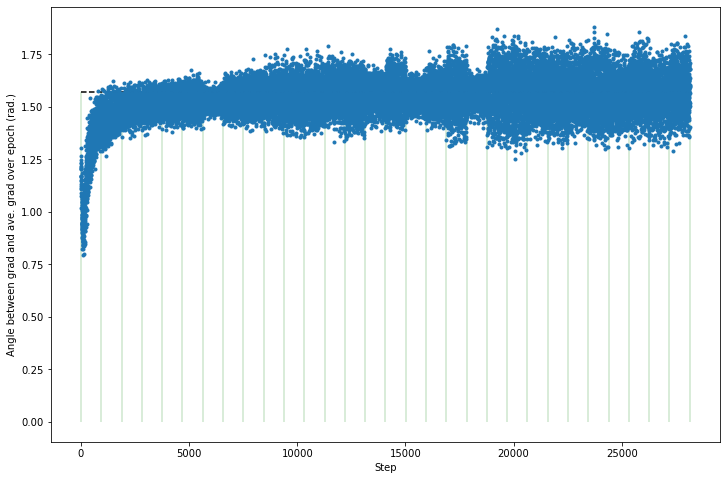

In [19]:
grad_dot_prod_withave = np.zeros((num_param_states))
for i in range(len(epoch_steps)):
    this_ave_grad = np.mean(grads[int(epoch_indices[i]):int(epoch_indices[i+1])], axis=0)
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
    #for j in range(int(epoch_indices[i+1]), int(epoch_indices[i+2])):
        grad_dot_prod[j] = np.arccos(np.dot(grads[j], this_ave_grad)/(np.linalg.norm(grads[j])*np.linalg.norm(this_ave_grad)))
        #grad_dot_prod[j] = np.dot(grads[j], this_ave_grad)/(np.linalg.norm(grads[j])*np.linalg.norm(this_ave_grad))
plt.figure(figsize=(12,8))
plt.vlines(epoch_indices, ymin=0, ymax=np.pi/2, color='g', alpha=0.2)
plt.hlines([np.pi/2], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.plot(grad_dot_prod, '.')
plt.xlabel("Step")
plt.ylabel("Angle between grad and ave. grad over epoch (rad.)")
#plt.xlim((0, 50))

sum of pred loss change: -49.45122847616312
sum of actual loss change: -0.7603151061133282
Mean diff. 0.001730309643569642


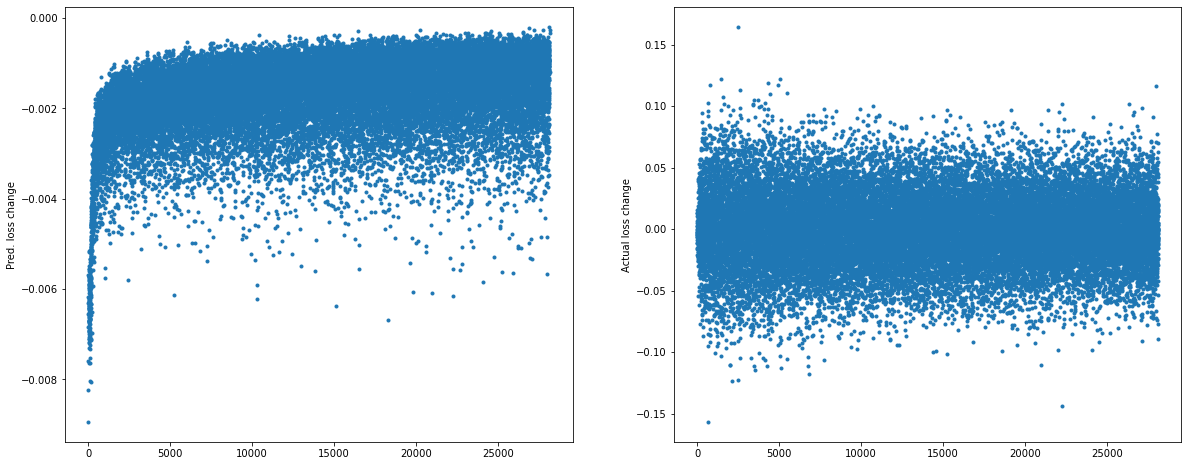

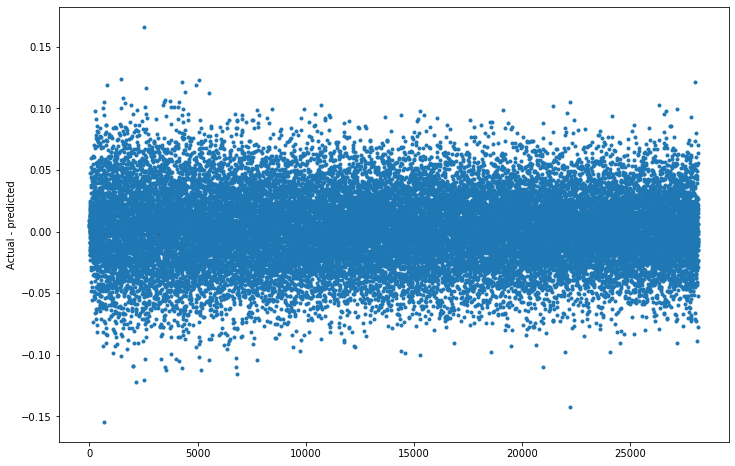

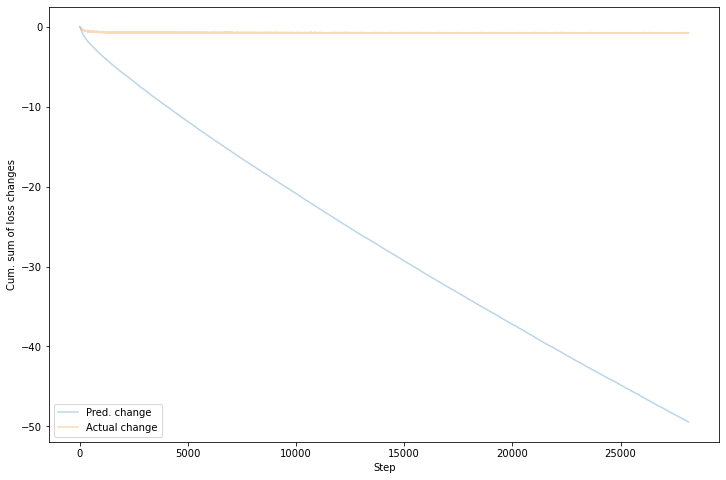

In [20]:
pred_loss_change = -1*np.multiply(np.linalg.norm(steps, axis=-1), np.linalg.norm(grads[:-1], axis=-1)) #size of step times size of grad
actual_loss_change = train_loss[1:] - train_loss[:-1]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(pred_loss_change, '.')
plt.ylabel("Pred. loss change")

print("sum of pred loss change:",  sum(pred_loss_change))

plt.subplot(1, 2, 2)
plt.plot(actual_loss_change, '.')
plt.ylabel("Actual loss change")

print("sum of actual loss change:", sum(actual_loss_change))

plt.figure(figsize=(12, 8))
plt.plot(actual_loss_change - pred_loss_change, '.')
plt.hlines([np.mean(actual_loss_change - -1*pred_loss_change)], xmin=0, xmax=num_param_states-1)
plt.ylabel("Actual - predicted")
print("Mean diff.", np.mean(actual_loss_change - pred_loss_change))

plt.figure(figsize=(12, 8))
plt.plot([sum(pred_loss_change[0:i]) for i in range(num_param_states)], label='Pred. change', alpha=0.3)
plt.plot([sum(actual_loss_change[0:i]) for i in range(num_param_states)], label="Actual change", alpha=0.3)
plt.ylabel("Cum. sum of loss changes")
plt.xlabel("Step")
plt.legend()


Text(0.5, 0, 'Epoch step')

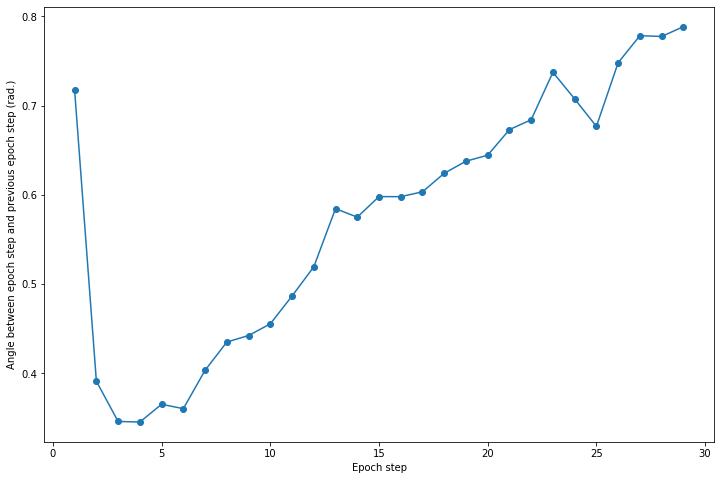

In [21]:
plt.figure(figsize=(12,8))
plt.plot([i+1 for i in range(len(epoch_steps)-1)], [np.arccos(np.dot(epoch_steps[i+1], epoch_steps[i])/(np.linalg.norm(epoch_steps[i+1])*np.linalg.norm(epoch_steps[i]))) for i in range(len(epoch_steps)-1)], 'o-')
plt.ylabel("Angle between epoch step and previous epoch step (rad.)")
plt.xlabel("Epoch step")

0.0 1.4607097324849923


Text(0, 0.5, 'Step j')

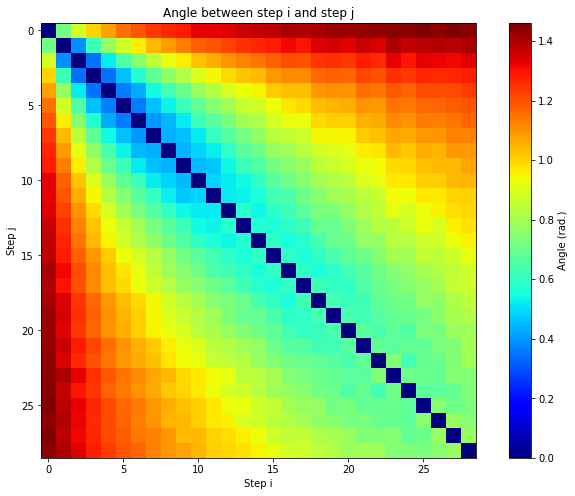

In [22]:
def angle_between(i, j, epoch_steps=epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.arccos(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))

angle_grid = np.zeros((num_epochs-1, num_epochs-1))

for i in range(num_epochs-1):
    for j in range(num_epochs-1):
        angle_grid[i, j] = angle_between(i, j)

import matplotlib.colors as colors        
norm1 = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))        

print(np.amin(angle_grid), np.amax(angle_grid))

plt.figure(figsize=(12,8))
plt.imshow(angle_grid, cmap=cm.jet)
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet), label='Angle (rad.)')
plt.title('Angle between step i and step j')
plt.xlabel('Step i')
plt.ylabel('Step j')

time: 104.65772294998169
time: 118.4954605102539
time: 121.79575204849243
time: 122.26885390281677
time: 121.5523374080658
time: 119.91377305984497
time: 121.8298237323761
time: 119.95371222496033
time: 125.1379988193512
time: 124.42232704162598
time: 124.70362305641174
time: 138.17197632789612
time: 92.73938918113708
time: 79.28561687469482
time: 74.14972019195557
time: 74.6451666355133
time: 74.40226030349731
time: 74.3486065864563
time: 74.10541200637817
time: 75.30910086631775
time: 74.25044512748718
time: 76.91478872299194
time: 77.25833415985107
time: 75.31829762458801
time: 74.94540643692017
time: 73.78660607337952
time: 75.26786947250366
time: 73.55359387397766
time: 74.19369316101074


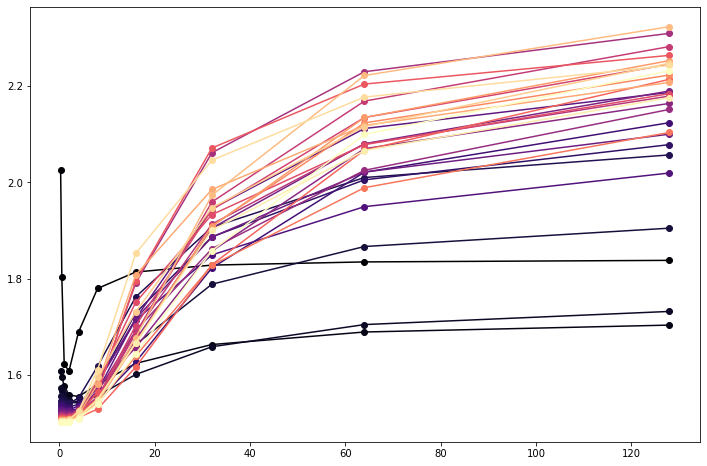

In [23]:
import time 
def scan_ahead(state_idx, num_steps=1, steps=[2**i for i in range(-2, 8)], epoch_states=epoch_states):
    losses = []
    for step in steps:
        #print(epoch_states[state_idx].shape, (epoch_states[state_idx+num_steps]-epoch_states[state_idx]).shape)
        param_state = epoch_states[state_idx] + step*(epoch_states[state_idx+num_steps]-epoch_states[state_idx])
        model.load_state_dict(vector_to_state_dict(param_state, model))
        this_loss,_ = test(train_data, model, loss_fn)
        losses.append(this_loss)
    return steps, losses

colors = cm.magma(np.linspace(0, 1, num_epochs-1))

plt.figure(figsize=(12,8))
for i in range(num_epochs-1):
    init_time = time.time()
    steps, losses = scan_ahead(i)
    print('time:', time.time()-init_time)
    plt.plot(steps, losses, 'o-', color=colors[i])

        